In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$F_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta^\top x$$

# Generate Communication Network

In [2]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

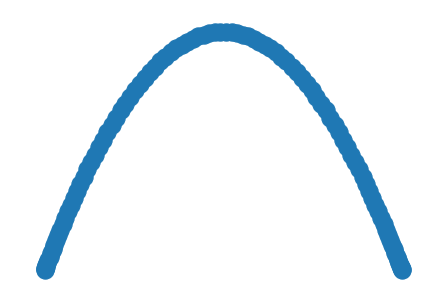

In [3]:
nx.draw_spectral(G)

# Problem Parameters

In [4]:
theta_0 = (1/(n+3))*np.ones((n,n))-np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
print(theta)
xi = n

[[-9.74861429e-01 -9.55447605e-03  1.22240570e-01 ...  8.33557339e-02
   1.35606387e-01  4.62098762e-02]
 [ 5.64477898e-04 -9.98547184e-01  1.29555736e-01 ... -1.41766643e-03
  -6.87532918e-02 -2.08743602e-02]
 [-3.72234367e-02 -5.16029685e-02 -8.44937397e-01 ...  1.75528954e-01
   2.71278731e-02  1.03591448e-01]
 ...
 [-3.49542283e-01  8.24749782e-02  1.63514429e-02 ... -1.17098833e+00
   7.58939172e-02  6.29858980e-02]
 [ 1.09198714e-01 -1.13114140e-01  7.74467894e-03 ...  2.61036791e-01
  -1.08544053e+00 -8.12532701e-02]
 [ 4.72152632e-02  3.50541255e-02  6.75602540e-02 ... -2.13025758e-02
  -1.25515447e-01 -1.04142014e+00]]


# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return 2*np.dot(theta,x) + xi

# Centralized GD

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 6217.51it/s]


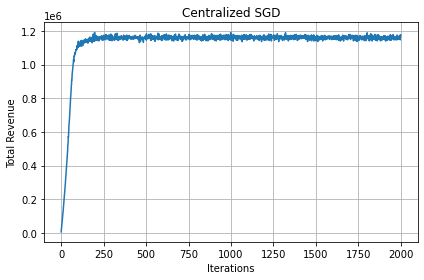

[ 48.73683919 100.         100.           0.         100.
 100.         100.         100.          94.41893562  35.89112417
 100.         100.          22.67527265 100.         100.
 100.         100.          74.57190546 100.         100.
 100.         100.         100.         100.          58.4144449
 100.         100.         100.         100.         100.
 100.         100.         100.           0.         100.
 100.         100.         100.         100.          83.9387013
 100.           9.95666988 100.         100.          26.81748165
 100.         100.          76.53073969 100.          63.55765607
 100.         100.         100.          47.5673345   16.99995556
 100.         100.         100.         100.           0.
 100.          58.52837025 100.         100.         100.
 100.         100.         100.          72.13932731 100.
 100.         100.         100.         100.          36.44488713
 100.         100.         100.         100.          95.81654984
 100.     

In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
p_max = n  # Set maximum price
rev = []
x_hist = []
iterations = 2000

# Run centralized GD
for i in trange(iterations):
    xi = n+np.random.randn(1)
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    x = np.clip(x,0,p_max)
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.title('Centralized SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/central_sgd.png')
plt.show()

print(x)

In [7]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

# Distributed SGD with synchronous information

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████████████████████████████████| 2000/2000 [00:13<00:00, 147.56it/s]


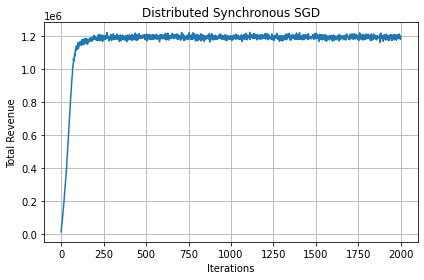

[ 48.88670563 100.         100.           0.         100.
 100.         100.         100.          94.54941105  36.01238056
 100.         100.          22.8442529  100.         100.
 100.         100.          74.74264871 100.         100.
 100.         100.         100.         100.          58.57069111
 100.         100.         100.         100.         100.
 100.         100.         100.           0.         100.
 100.         100.         100.         100.          84.03193657
 100.          10.02581348 100.         100.          26.93740209
 100.         100.          76.66007225 100.          63.6262478
 100.         100.         100.          47.64988525  17.09535813
 100.         100.         100.         100.           0.
 100.          58.58860928 100.         100.         100.
 100.         100.         100.          72.29812337 100.
 100.         100.         100.         100.          36.53008961
 100.         100.         100.         100.          95.89003656
 100.    

In [8]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_cent = []
x_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    x_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        X[j] += step*grad_revenue(X[j],theta,xi)
        temp.append(total_revenue(X[j],theta,xi))
    rev_cent.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_cent)
plt.grid()
plt.title('Distributed Synchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_sync.png')
plt.show()

print(np.mean(X,axis=0))

In [9]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

In [10]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.29523930969338924


# Distributed SGD with asynchronous information

100%|██████████████████████████████████████| 2000/2000 [00:13<00:00, 145.17it/s]


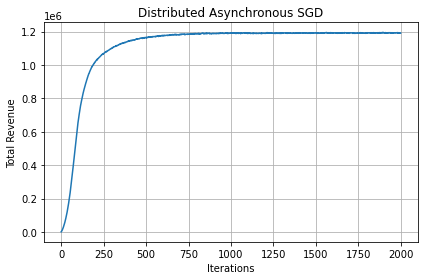

[ 48.83453836 100.         100.           0.         100.
 100.         100.         100.          94.49699836  35.96374247
 100.         100.          22.78774043 100.         100.
 100.         100.          74.6863054  100.         100.
 100.         100.         100.         100.          58.5161669
 100.         100.         100.         100.         100.
 100.         100.         100.           0.         100.
 100.         100.         100.         100.          83.98546116
 100.           9.98378818 100.         100.          26.88648857
 100.         100.          76.6080921  100.          63.5845196
 100.         100.         100.          47.60456614  17.04576644
 100.         100.         100.         100.           0.
 100.          58.54411046 100.         100.         100.
 100.         100.         100.          72.24585474 100.
 100.         100.         100.         100.          36.48552924
 100.         100.         100.         100.          95.84731428
 100.     

In [11]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_async.png')
plt.show()

print(np.mean(X,axis=0))

In [12]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.10791631927178046


# Fully connected graph

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 117.72it/s]


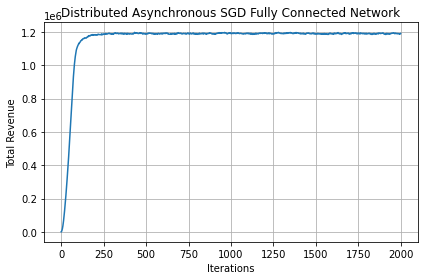

[ 48.77178884 100.         100.           0.         100.
 100.         100.         100.          94.44658598  35.912911
 100.         100.          22.7197285  100.         100.
 100.         100.          74.61684289 100.         100.
 100.         100.         100.         100.          58.45423455
 100.         100.         100.         100.         100.
 100.         100.         100.           0.         100.
 100.         100.         100.         100.          83.9508774
 100.           9.95904163 100.         100.          26.84198746
 100.         100.          76.55715864 100.          63.55906917
 100.         100.         100.          47.57699059  17.01651486
 100.         100.         100.         100.           0.
 100.          58.52970016 100.         100.         100.
 100.         100.         100.          72.17743976 100.
 100.         100.         100.         100.          36.45419574
 100.         100.         100.         100.          95.82275284
 100.      

In [13]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.erdos_renyi_graph(n,0.2)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Fully Connected Network')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_fc.png')
plt.show()

print(np.mean(X,axis=0))

In [14]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.014134687545720843


# Erdos Renyi random graph p=0.2

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 118.68it/s]


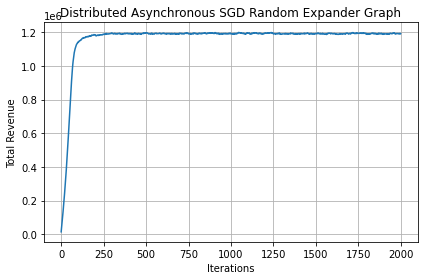

[ 48.76819126 100.         100.           0.         100.
 100.         100.         100.          94.44520057  35.91334345
 100.         100.          22.71357991 100.         100.
 100.         100.          74.61055642 100.         100.
 100.         100.         100.         100.          58.44861713
 100.         100.         100.         100.         100.
 100.         100.         100.           0.         100.
 100.         100.         100.         100.          83.95277276
 100.           9.96260039 100.         100.          26.84050176
 100.         100.          76.55648997 100.          63.56324808
 100.         100.         100.          47.57823053  17.01596276
 100.         100.         100.         100.           0.
 100.          58.53295543 100.         100.         100.
 100.         100.         100.          72.17323741 100.
 100.         100.         100.         100.          36.45608844
 100.         100.         100.         100.          95.82410891
 100.   

In [15]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Random Expander Graph')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_expander.png')
plt.show()

print(np.mean(X,axis=0))

In [16]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.011578231581213924
